In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
import sys

sys_epsilon = sys.float_info.epsilon

In [2]:
headers = ["t", "Ux", "Uy", "Uz", 
           "G1", "G2", "G3", "G4", "G5", "G6", 
           "S1", "S2", "S3", "S4", "S5", "S6", 
           "UUp1", "UUp2", "UUp3", "UUp4", "UUp5", "UUp6", 
           "Cs"]

R103 = pd.read_csv('./datasets/fieldData_R103_norm.txt', sep=' ', names=headers)
R503 = pd.read_csv('./datasets/fieldData_R503_norm.txt', sep=' ', names=headers)
R104 = pd.read_csv('./datasets/fieldData_R104_norm.txt', sep=' ', names=headers)

In [3]:
R103.head()

,t,Ux,Uy,Uz,G1,G2,G3,G4,G5,G6,...,S4,S5,S6,UUp1,UUp2,UUp3,UUp4,UUp5,UUp6,Cs
0,-1.027122,-0.000607,-0.001033,0.001586,0.003769,-0.000243,-0.000310,0.001519,-0.004942,-0.002082,...,-0.004942,0.000056,-0.001784,-0.134213,-0.010852,0.009912,-0.153644,-0.045258,-0.150407,-0.232084
1,-1.027122,0.048423,-0.002944,-0.000262,0.021788,-0.000289,-0.000408,0.001519,-0.017760,-0.002090,...,-0.017760,0.000042,-0.015981,-0.134199,-0.010853,0.009911,-0.153644,-0.045258,-0.150407,-0.191414
2,-1.027122,0.146858,-0.000820,0.001179,0.005336,0.000219,0.000182,0.001882,-0.003509,-0.002079,...,-0.003509,0.000060,-0.004908,-0.133998,-0.010854,0.009910,-0.153644,-0.045258,-0.150406,0.044781
3,-1.027122,0.095208,-0.000137,0.002144,-0.003282,-0.000302,-0.000333,0.001519,0.001063,-0.002076,...,0.001063,0.000066,0.002495,-0.133893,-0.010854,0.009910,-0.153644,-0.045258,-0.150406,0.088803
4,-1.027122,0.078927,-0.000084,0.001453,-0.000148,-0.000061,-0.000199,0.001519,0.001425,-0.002077,...,0.001425,0.000064,-0.002813,-0.133738,-0.010855,0.009909,-0.153644,-0.045258,-0.150406,-0.099000


In [4]:
frames = [R103, R503, R104]
df = pd.concat(frames)
df.shape

(26697608, 23)

In [5]:
M1_headers = ['Ux', 'Uy', 'Uz', 'S1',  'S2', 'S3', 'S4', 'S5', 'S6', 'Cs']
M2_headers = ['G1', 'G2', 'G3', 'G4', 'G5', 'G6', 'S1',  'S2', 'S3', 'S4', 'S5', 'S6', 'Cs']
M3_headers = ['Ux', 'Uy', 'Uz', 'UUp1',  'UUp2', 'UUp3', 'UUp4', 'UUp5', 'UUp6', 'Cs']
M4_headers = ['G1', 'G2', 'G3', 'G4', 'G5', 'G6', 'UUp1',  'UUp2', 'UUp3', 'UUp4', 'UUp5', 'UUp6', 'Cs']

M1_103 = R103.filter(M1_headers, axis=1)
M2_103 = R103.filter(M2_headers, axis=1)
M3_103 = R103.filter(M3_headers, axis=1)
M4_103 = R103.filter(M4_headers, axis=1)

M1_503 = R503.filter(M1_headers, axis=1)
M2_503 = R503.filter(M2_headers, axis=1)
M3_503 = R503.filter(M3_headers, axis=1)
M4_503 = R503.filter(M4_headers, axis=1)

M1_104 = R104.filter(M1_headers, axis=1)
M2_104 = R104.filter(M2_headers, axis=1)
M3_104 = R104.filter(M3_headers, axis=1)
M4_104 = R104.filter(M4_headers, axis=1)

M1 = df.filter(M1_headers, axis=1)
M2 = df.filter(M2_headers, axis=1)
M3 = df.filter(M3_headers, axis=1)
M4 = df.filter(M4_headers, axis=1)

In [6]:
M1.shape, M2.shape

((26697608, 10), (26697608, 13))

In [8]:
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

In [148]:
dt = M2_104
dt_name = namestr(M2_104, globals())[0]
output_size = 1
input_size = dt.shape[1] - output_size 
neurons_per_layer = [60, 60, 60, 60, 60] #[120, 60, 30, 20, 10, 10, 20, 30, 60]
hidden_layers = len(neurons_per_layer)   
#latent_size = 20  

In [149]:
dt.head()

,G1,G2,G3,G4,G5,G6,S1,S2,S3,S4,S5,S6,Cs
0,-0.000859,0.001333,0.000589,0.000236,-0.001709,0.000490,-0.000859,0.000819,-0.000810,-0.001709,0.001019,0.001444,-1.929617
1,0.007403,0.001420,0.000656,0.000236,-0.004601,0.000669,0.007403,0.000857,-0.000455,-0.004601,0.001303,-0.002616,-0.183021
2,0.015995,0.001564,0.000896,0.000236,-0.008244,-0.000488,0.015995,0.000920,-0.000355,-0.008244,-0.000530,-0.010018,-0.124142
3,0.011368,0.001738,0.001067,0.000236,-0.001409,-0.001457,0.011368,0.000995,-0.000283,-0.001409,-0.002066,-0.005366,-0.258416
4,-0.009122,0.000399,0.000139,-0.000411,0.004366,-0.001645,-0.009122,-0.000244,-0.001325,0.004366,-0.002363,0.004082,0.106165


In [150]:
#dt.to_csv(f'./{dt_name}.txt', sep=' ', index=False, encoding='utf-8', header=False)

In [151]:
mask = np.random.rand(len(dt)) < 0.8
train_val = dt[mask]
test = dt[~mask].to_numpy()

mask = np.random.rand(len(train_val)) < 0.8
train = train_val[mask].to_numpy()
val = train_val[~mask].to_numpy()

In [152]:
dt.shape, train.shape[0], val.shape[0], test.shape[0]

((17552029, 13), 11233340, 2808913, 3509776)

In [153]:
batch_sz_trn = 4096
batch_sz_val = int(batch_sz_trn / 4)
batch_sz_tst = int(batch_sz_trn / 4)

train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=batch_sz_trn, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val, batch_size=batch_sz_val, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size=batch_sz_tst, shuffle=True)

In [154]:
data_iter = iter(train_loader)
next(data_iter)[0]

tensor([-0.0336,  0.0658,  0.0214,  0.0293, -0.0296, -0.0316, -0.0336,  0.0583,
         0.0195, -0.0296, -0.0483,  0.0102,  0.6077], dtype=torch.float64)

In [155]:
def coeff_determination(y_true, y_pred):
    SS_res = torch.sum(torch.square( y_true - y_pred ))
    SS_tot = torch.sum(torch.square( y_true - torch.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + sys_epsilon) )

In [156]:
class MLPModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, neurons_per_layer):
        super(MLPModel, self).__init__()

        layers = []
        layers.append(nn.Linear(input_size, neurons_per_layer[0]))
        layers.append(nn.ReLU())

        for i in range(1, hidden_layers):
            layers.append(nn.Linear(neurons_per_layer[i - 1], neurons_per_layer[i]))
            layers.append(nn.ReLU())

        layers.append(nn.Linear(neurons_per_layer[-1], output_size))

        self.block = nn.Sequential(*layers)

    def forward(self, x):
        x = self.block(x)
        return x


In [157]:
class Autoencoder(nn.Module):
    def __init__(self, input_size, latent_size, hidden_layers, neurons_per_layer):
        super(Autoencoder, self).__init__()

        # Encoder layers
        encoder_layers = []
        encoder_layers.append(nn.Linear(input_size, neurons_per_layer[0]))
        encoder_layers.append(nn.ReLU())

        for i in range(1, hidden_layers):
            encoder_layers.append(nn.Linear(neurons_per_layer[i - 1], neurons_per_layer[i]))
            encoder_layers.append(nn.ReLU())

        encoder_layers.append(nn.Linear(neurons_per_layer[-1], latent_size))
        self.encoder = nn.Sequential(*encoder_layers)

        # Decoder layers
        decoder_layers = []
        decoder_layers.append(nn.Linear(latent_size, neurons_per_layer[-1]))
        decoder_layers.append(nn.ReLU())

        for i in range(hidden_layers - 1, 0, -1):
            decoder_layers.append(nn.Linear(neurons_per_layer[i], neurons_per_layer[i - 1]))
            decoder_layers.append(nn.ReLU())

        decoder_layers.append(nn.Linear(neurons_per_layer[0], 1))
        self.decoder = nn.Sequential(*decoder_layers)

    def forward(self, x):
        # Encode input
        encoded = self.encoder(x)

        # Decode
        decoded = self.decoder(encoded)

        return decoded


In [158]:
model = MLPModel(input_size=input_size, 
                 output_size=output_size, 
                 hidden_layers=hidden_layers, 
                 neurons_per_layer=neurons_per_layer)

In [159]:
#model = Autoencoder(input_size, latent_size, hidden_layers, neurons_per_layer)

In [160]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=3, gamma=0.2)

In [161]:
#criterion = nn.MSELoss()  # Mean Squared Error loss for reconstruction
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [162]:
device = torch.device("cuda")
model.to(device)
model.double()

MLPModel(
  (block): Sequential(
    (0): Linear(in_features=12, out_features=60, bias=True)
    (1): ReLU()
    (2): Linear(in_features=60, out_features=60, bias=True)
    (3): ReLU()
    (4): Linear(in_features=60, out_features=60, bias=True)
    (5): ReLU()
    (6): Linear(in_features=60, out_features=60, bias=True)
    (7): ReLU()
    (8): Linear(in_features=60, out_features=60, bias=True)
    (9): ReLU()
    (10): Linear(in_features=60, out_features=1, bias=True)
  )
)

In [163]:
class EarlyStopper:
    def __init__(self, patience=1, path=None):
        self.patience = patience
        self.path = path
        self.counter = 0
        self.min_val_loss = float('inf')

    def early_stop(self, model_stat, val_loss):
        if val_loss < self.min_val_loss:
            torch.save(model_stat, self.path)
            self.min_val_loss = val_loss
            self.counter = 0
        elif val_loss > (self.min_val_loss + sys_epsilon):
            self.counter += 1
            if self.counter >= self.patience:
                print('+++ Early Stopping is reached! +++')
                return True
        return False

In [ ]:
epochs = 6000
best = 1e6
PATH = f"./best_model_{dt_name}.pt"

early_stopper = EarlyStopper(patience=50, path=PATH)
                             
for epoch in range(epochs):
    model.train()
    Loss_train = 0 
    Loss_val = 0
    coeff_train = 0
    coeff_val = 0
    with tqdm(train_loader, unit="batch") as trainer:
        for batch in trainer:
            trainer.set_description("Train")
            train_feat = batch[:, 0:-1].to(device)
            train_labs = batch[:, -1].to(device)
            train_pred = model(train_feat).squeeze()
            train_loss = torch.nn.functional.mse_loss(train_pred, train_labs)
            train_coef = coeff_determination(train_labs, train_labs) 

            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

            Loss_train += train_loss.item()
            coeff_train += train_coef

        Loss_train /= batch_sz_trn
        coeff_train /= batch_sz_trn

    model.eval()
    with tqdm(val_loader, unit="batch") as validator:
        for batch in validator:
            validator.set_description("Valdt")
            val_feat = batch[:, 0:-1].to(device)
            val_labs = batch[:, -1].to(device)
            val_pred = model(val_feat).squeeze()
            val_loss = torch.nn.functional.mse_loss(val_pred, val_labs)
            val_coef = coeff_determination(val_labs, val_labs) 

            Loss_val += val_loss.item()
            coeff_val += val_coef

        Loss_val /= batch_sz_val
        coeff_val /= batch_sz_val
    
    if early_stopper.early_stop(model.state_dict(), Loss_val):             
        break
        
    print(f"Epoch: {epoch} / {epochs}, \n Train -- Loss: {Loss_train}, Coeff: {coeff_train} \n Val   -- Loss: {Loss_val}, Coeff: {coeff_val} \n\n")

Valdt: 100%|██████████| 2744/2744 [00:12<00:00, 224.71batch/s]


Epoch: 0 / 6000, 
 Train -- Loss: 0.6029153233685306, Coeff: 0.669677734375 
 Val   -- Loss: 2.4298693905585673, Coeff: 2.6796875 




Valdt: 100%|██████████| 2744/2744 [00:11<00:00, 230.51batch/s]


Epoch: 1 / 6000, 
 Train -- Loss: 0.5856108433300241, Coeff: 0.669677734375 
 Val   -- Loss: 2.4100662172024037, Coeff: 2.6796875 




Valdt: 100%|██████████| 2744/2744 [00:12<00:00, 227.72batch/s]


Epoch: 2 / 6000, 
 Train -- Loss: 0.5779636276868633, Coeff: 0.669677734375 
 Val   -- Loss: 2.377790029127911, Coeff: 2.6796875 




Valdt: 100%|██████████| 2744/2744 [00:12<00:00, 227.57batch/s]


Epoch: 3 / 6000, 
 Train -- Loss: 0.5710550626819765, Coeff: 0.669677734375 
 Val   -- Loss: 2.3436258954864457, Coeff: 2.6796875 




Valdt: 100%|██████████| 2744/2744 [00:11<00:00, 230.07batch/s]


Epoch: 4 / 6000, 
 Train -- Loss: 0.5657533292328848, Coeff: 0.669677734375 
 Val   -- Loss: 2.3328879394819353, Coeff: 2.6796875 




Valdt: 100%|██████████| 2744/2744 [00:12<00:00, 225.81batch/s]


Epoch: 5 / 6000, 
 Train -- Loss: 0.5621590802242719, Coeff: 0.669677734375 
 Val   -- Loss: 2.3258892196396816, Coeff: 2.6796875 




Valdt:  61%|██████    | 1676/2744 [00:07<00:04, 228.22batch/s]

In [142]:
data_iter = iter(train_loader)
next(data_iter)[:,0:-1]

tensor([[ 1.4572e-01, -3.3430e-01,  9.2579e-02,  ..., -5.3022e-02,
         -1.9939e-01, -3.7249e-02],
        [-5.7070e-04,  5.0673e-03,  6.9486e-03,  ..., -1.8234e-03,
          3.2142e-04,  4.1798e-03],
        [ 6.7860e-02,  1.4044e-02, -3.3947e-02,  ...,  1.7192e-01,
         -3.5996e-02,  1.9579e-02],
        ...,
        [ 3.3745e-02, -1.8838e-02,  1.0833e-01,  ...,  1.1703e-01,
         -1.3298e-01,  5.7494e-02],
        [-7.8855e-02,  1.8614e-01,  7.8150e-02,  ...,  1.5090e-01,
          6.0991e-02, -3.4914e-02],
        [ 1.3368e-01,  2.2587e-02,  1.3941e-03,  ...,  2.2377e-03,
          1.4148e-03,  8.5328e-04]], dtype=torch.float64)

In [143]:
traced_script_module = torch.jit.trace(model, next(data_iter)[:,0:-1].to(device))
traced_script_module.save(f"traced_model_{dt_name}.pt")

In [144]:
model = MLPModel(input_size=input_size, 
                 output_size=output_size, 
                 hidden_layers=hidden_layers, 
                 neurons_per_layer=neurons_per_layer)

model.load_state_dict(torch.load(PATH))
model.eval()
model.double()

MLPModel(
  (block): Sequential(
    (0): Linear(in_features=9, out_features=60, bias=True)
    (1): ReLU()
    (2): Linear(in_features=60, out_features=60, bias=True)
    (3): ReLU()
    (4): Linear(in_features=60, out_features=60, bias=True)
    (5): ReLU()
    (6): Linear(in_features=60, out_features=60, bias=True)
    (7): ReLU()
    (8): Linear(in_features=60, out_features=60, bias=True)
    (9): ReLU()
    (10): Linear(in_features=60, out_features=1, bias=True)
  )
)

In [145]:
pred = model(torch.from_numpy(test[:,:-1]))
pred

tensor([[-0.1567],
        [ 0.0670],
        [-0.1878],
        ...,
        [-0.1770],
        [-0.1467],
        [-0.0442]], dtype=torch.float64, grad_fn=<AddmmBackward0>)

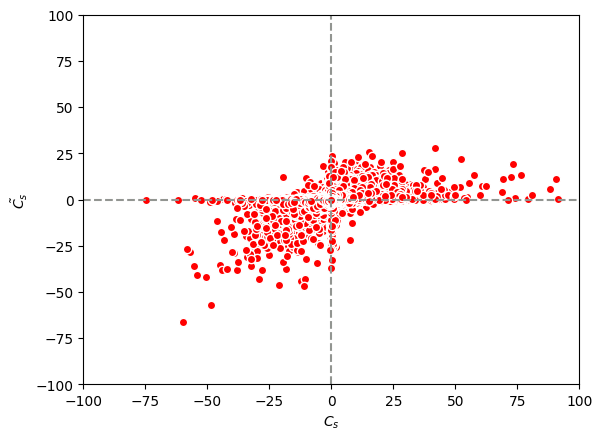

In [146]:
plt.scatter(test[:,-1], pred.detach().numpy(), edgecolor='white', color='red')
plt.plot([0, 0], [-100, 100], '--', color='#929591')
plt.plot([-100, 100], [0, 0], '--', color='#929591')
plt.xlim([-100, 100])
plt.ylim([-100, 100])
plt.xlabel(r'$C_s$')
plt.ylabel(r'$\tilde{C_s}$')
plt.savefig(f'../nnTraining/Results/{dt_name}_correlation.png')

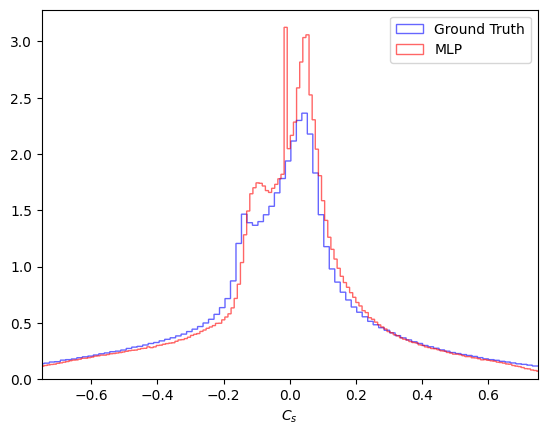

In [147]:
plt.hist(test[:,-1], bins=10000, density=True, alpha=0.6, histtype=u'step', color='blue')
plt.hist(pred.detach().numpy(), bins=10000, density=True, alpha=0.6, histtype=u'step', color='red')
plt.xlim([-0.75, 0.75])
plt.xlabel(r'$C_s$')
plt.legend(['Ground Truth', 'MLP'])
plt.savefig(f'../nnTraining/Results/{dt_name}_density.png')